In [1]:
import numpy as np
from scipy.special import psi
from math import log, exp

def discrete_continuous_info(d, c, k=3, base=exp(1)):
    """
    Estimates mutual information between a discrete vector 'd' and continuous vectors 'c'.
    
    Args:
        d (np.ndarray): Discrete array of shape (1, N) or (N,)
        c (np.ndarray): Continuous data of shape (M, N) where M is feature dim
        k (int): Number of nearest neighbors
        base (float): Logarithm base (default: natural log)
    
    Returns:
        f (float): Estimated mutual information
        V (np.ndarray): Volume estimates for each sample
    """
    d = np.asarray(d)
    c = np.asarray(c)

    if d.ndim == 1:
        d = d.reshape(1, -1)
    if c.ndim == 1:
        c = c.reshape(1, -1)

    N = c.shape[1]
    symbol_IDs = np.zeros(N, dtype=int)
    first_symbol = []
    c_split = []
    cs_indices = []
    num_d_symbols = 0

    # Bin continuous data by discrete symbols
    for i in range(N):
        found = False
        for j in range(num_d_symbols):
            if d[:, i] == d[:, first_symbol[j]]:
                symbol_IDs[i] = j
                found = True
                break
        if not found:
            symbol_IDs[i] = num_d_symbols
            first_symbol.append(i)
            c_split.append([])
            cs_indices.append([])
            num_d_symbols += 1

        c_split[symbol_IDs[i]].append(c[:, i])
        cs_indices[symbol_IDs[i]].append(i)

    # Convert to numpy arrays
    for i in range(num_d_symbols):
        c_split[i] = np.column_stack(c_split[i])

    m_tot = 0
    av_psi_Nd = 0
    V = np.zeros(N)
    all_c_distances = np.zeros(N)
    psi_ks = 0

    for c_bin in range(num_d_symbols):
        n_bin = c_split[c_bin].shape[1]
        one_k = min(k, n_bin - 1)

        if one_k > 0:
            for pivot in range(n_bin):
                # Compute distances within bin
                c_pivot = c_split[c_bin][:, pivot]
                c_distances = np.linalg.norm(c_split[c_bin] - c_pivot[:, None], axis=0)
                sorted_distances = np.sort(c_distances)
                eps_over_2 = sorted_distances[one_k + 1]  # skip pivot

                # Count total points within volume
                all_distances = np.linalg.norm(c - c_pivot[:, None], axis=0)
                m = max(np.sum(all_distances <= eps_over_2) - 1, 0)

                m_tot += psi(m)
                V[cs_indices[c_bin][pivot]] = (2 * eps_over_2) ** d.shape[0]
        else:
            m_tot += psi(num_d_symbols * 2)

        p_d = n_bin / N
        av_psi_Nd += p_d * psi(p_d * N)
        psi_ks += p_d * psi(max(one_k, 1))

    f = (psi(N) - av_psi_Nd + psi_ks - m_tot / N) / log(base)
    return f, V


In [8]:
import numpy as np
from scipy.spatial import distance
from scipy.special import digamma
from math import log, exp

def discrete_continuous_info_2(d, c, k=3, base=np.e):
    """
    Estimates the mutual information between a discrete vector `d`
    and a continuous matrix `c` using a nearest-neighbor approach.
    
    Parameters:
    d (np.ndarray): 1D array of discrete labels (shape: [n_samples])
    c (np.ndarray): 2D array of continuous data (shape: [n_features, n_samples])
    k (int): number of nearest neighbors (default: 3)
    base (float): log base for the mutual information (default: natural log)
    
    Returns:
    f (float): estimated mutual information
    V (np.ndarray): estimated local volume per point
    """
    n_samples = c.shape[1]
    symbol_IDs = np.zeros(n_samples, dtype=int)
    c_split = {}
    cs_indices = {}
    unique_labels = []
    num_d_symbols = 0

    # Bin the data by discrete labels
    for i in range(n_samples):
        label = d[i]
        if label not in unique_labels:
            unique_labels.append(label)
            num_d_symbols += 1
            c_split[label] = []
            cs_indices[label] = []
        c_split[label].append(c[:, i])
        cs_indices[label].append(i)

    for label in c_split:
        c_split[label] = np.column_stack(c_split[label])  # Convert to numpy array

    m_tot = 0
    av_psi_Nd = 0
    V = np.zeros(n_samples)
    psi_ks = 0

    for label in c_split:
        group_c = c_split[label]
        group_indices = cs_indices[label]
        n_group = group_c.shape[1]
        one_k = min(k, n_group - 1)

        if one_k > 0:
            for pivot in range(n_group):
                pivot_vec = group_c[:, pivot].reshape(-1, 1)
                diffs = group_c - pivot_vec
                distances = np.linalg.norm(diffs, axis=0)
                sorted_distances = np.sort(distances)
                eps_over_2 = sorted_distances[one_k + 1]  # k-th neighbor (skip self)

                # Count neighbors in all data within this radius
                full_diffs = c - pivot_vec
                all_distances = np.linalg.norm(full_diffs, axis=0)
                m = max(np.sum(all_distances <= eps_over_2) - 1, 0)
                m_tot += digamma(m + 1)  # +1 for numerical stability
                V[group_indices[pivot]] = (2 * eps_over_2) ** c.shape[0]
        else:
            m_tot += digamma(num_d_symbols * 2)

        p_d = n_group / n_samples
        av_psi_Nd += p_d * digamma(n_group)
        psi_ks += p_d * digamma(max(one_k, 1))

    f = (digamma(n_samples) - av_psi_Nd + psi_ks - m_tot / n_samples) / log(base)
    return f, V


In [78]:
import numpy as np
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors
import sys

np.set_printoptions(threshold=sys.maxsize)

def compute_kmu(x, y, per_filter=True, average=True, n_neighbors=3):
    """
    Compute mutual information between continuous and discrete variables.
    :param x: ndarray, shape (batch_size, n_filters, height, width)
    :param y: ndarray, shape (batch_size,)
    :param per_filter: bool, compute MI per 3D filter or on full tensor
    :param average: bool, average the MI values if per_filter is True
    :param n_neighbors: int, number of nearest neighbors
    :return: float or list of floats
    """
    if per_filter:
        filters_count = x.shape[1]
        x = x.reshape(x.shape[0], filters_count, -1)
        kmu = [mu_approximate(x[:, i, :], y, n_neighbors=n_neighbors) for i in range(filters_count)]
    else:
        x = x.reshape(x.shape[0], -1)
        kmu = mu_approximate(x, y, n_neighbors=n_neighbors)

    if average and isinstance(kmu, list):
        kmu = np.mean(kmu)

    return kmu


def nn_sklearn(x, k):
    """Compute nearest neighbors using sklearn"""
    nn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='euclidean')
    nn.fit(x)
    d, _ = nn.kneighbors(x)
    return d


def binary_search(arr, value):
    """Find index to insert value into sorted arr (like bisect.bisect)"""
    low, high = 0, len(arr)
    while low < high:
        mid = (low + high) // 2
        if arr[mid] < value:
            low = mid + 1
        else:
            high = mid
    return low


def mu_approximate(c, d, n_neighbors, base):
    """
    Mutual information between continuous and discrete variable
    :param c: ndarray, shape (n_samples, n_features) or (n_samples, n_variables, n_features)
    :param d: ndarray, shape (n_samples,)
    :param n_neighbors: number of neighbors for MI estimation
    :return: MI estimate(s)
    """
    # Handle multidimensional variables: (n_samples, n_variables, n_features)
    if c.ndim == 3:
        return [mu_approximate(c[:, i, :], d, n_neighbors) for i in range(c.shape[1])]

    n_samples = c.shape[0]
    radius = np.empty(n_samples)
    label_counts = np.empty(n_samples)
    k_all = np.empty(n_samples)

    for label in np.unique(d):
        mask = (d == label).reshape(-1)
        count = np.sum(mask)
        if count > n_neighbors + 1:
            k = min(n_neighbors, count - 1)
            dist = nn_sklearn(c[mask, :], k=k)
            radius[mask] = np.nextafter(dist[:, -1], 0)
            k_all[mask] = k
        label_counts[mask] = count

    # Ignore points with unique labels
    mask = label_counts > 1
    if np.sum(mask) == 0:
        return 0.0

    n_samples = np.sum(mask)
    label_counts = label_counts[mask]
    k_all = k_all[mask]
    c = c[mask]
    radius_sklearn = radius[mask]

    D = nn_sklearn(c, k=100)
    idc_counts = np.array([max(0, binary_search(D[i], radius_sklearn[i])) for i in range(c.shape[0])])

    mi = (digamma(n_samples) + np.mean(digamma(k_all)) -
          np.mean(digamma(label_counts)) -
          np.mean(digamma(idc_counts + 1))) / log(base)

    if mi > 100:
        mi = -1
    return max(0, mi)


Estimated Mutual Information I(D; C): 0.0553
Estimated Mutual Information I(D; C): -0.0291
Estimated Mutual Information I(D; C): 0.0904


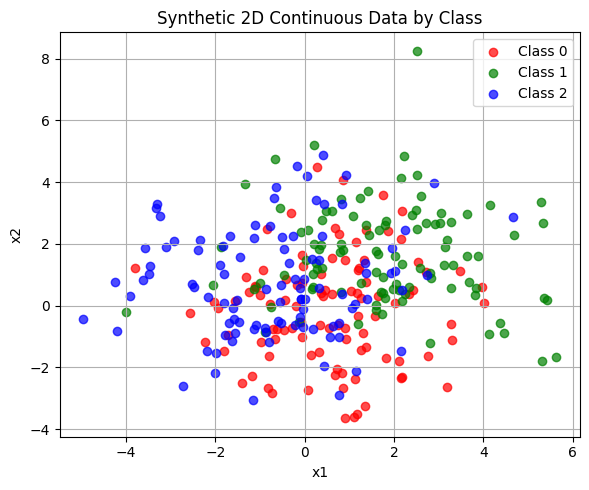

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Generate synthetic data ---
np.random.seed(42)
N = 300  # number of samples
dim = 2  # dimensionality of continuous variable

# Create 3 discrete classes
n_classes = 3
samples_per_class = N // n_classes

c = []
d = []

for i in range(n_classes):
    # Continuous values clustered around different means
    mean = np.random.randn(dim) * 1.5
    cov = np.eye(dim) * 3
    cluster = np.random.multivariate_normal(mean, cov, size=samples_per_class).T
    c.append(cluster)
    d += [i] * samples_per_class

# Stack all continuous samples into a (dim, N) array
c = np.hstack(c)
d = np.array(d).reshape(1, -1)

# --- Step 2: Estimate mutual information ---
mi, V = discrete_continuous_info(d, c, k=5, base=np.e)
print(f"Estimated Mutual Information I(D; C): {mi:.4f}")
mi, V = discrete_continuous_info_2(d.reshape(-1), c, k=5, base=np.e)
print(f"Estimated Mutual Information I(D; C): {mi:.4f}")
mi = mu_approximate(c.reshape(N, -1), d.reshape(-1, 1), 5, np.e)
print(f"Estimated Mutual Information I(D; C): {mi:.4f}")

# --- Step 3: Optional - Visualize data ---
plt.figure(figsize=(6, 5))
colors = ['red', 'green', 'blue', 'purple']
for i in range(n_classes):
    class_data = c[:, d.flatten() == i]
    plt.scatter(class_data[0], class_data[1], label=f'Class {i}', alpha=0.7, color=colors[i])
plt.title("Synthetic 2D Continuous Data by Class")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
def mutual_information_discrete(samples):
    """
    Estimate the mutual information between two discrete variables using NumPy only.
    
    Parameters:
        samples (np.ndarray): A 2D array of shape (n_samples, 2) where each row is (x, y).
        
    Returns:
        float: Estimated mutual information in bits.
    """
    if samples.shape[1] != 2:
        raise ValueError("Input array must have exactly two columns (variables).")
    
    x = samples[:, 0]
    y = samples[:, 1]
    
    # Encode x and y into integer labels if they're not already (handles strings or non-contiguous ints)
    x_vals, x_idx = np.unique(x, return_inverse=True)
    y_vals, y_idx = np.unique(y, return_inverse=True)
    
    # Compute joint histogram
    joint_hist = np.histogram2d(x_idx, y_idx, bins=(len(x_vals), len(y_vals)))[0]
    joint_prob = joint_hist / joint_hist.sum()
    
    # Compute marginal probabilities
    px = joint_prob.sum(axis=1, keepdims=True)  # shape: (n_x, 1)
    py = joint_prob.sum(axis=0, keepdims=True)  # shape: (1, n_y)
    
    # Avoid division by zero and log(0) by masking
    non_zero = joint_prob > 0
    mi_matrix = np.zeros_like(joint_prob)
    mi_matrix[non_zero] = joint_prob[non_zero] * np.log2(joint_prob[non_zero] / (px @ py)[non_zero])
    
    return mi_matrix.sum()

In [89]:
import pandas as pd
import numpy as np
import math
import json


def make_broadcast(step_data, n_agents=4):
    if np.issubdtype(step_data["mess_0"].dtype, np.integer): # discrete
        br = []
        for a_i in range(n_agents):
            if len(step_data[f"mess_{a_i}"]) > 1:
                mess = list(step_data[f"mess_{a_i}"])
                end_i = mess.index(1)

                br.extend(mess[:end_i])

        return "-".join(map(str, br))
    else: # continuous
        br = [step_data[f"mess_{a_i}"] for a_i in range(n_agents)]
        return np.concatenate(br)
    

def load_n_prep_data(path):
    df = pd.read_csv(path, index_col=0)
    df = df.fillna('')

    for c in df.columns:
        df[c] = df[c].apply(json.loads)
        if "obs" in c or "mess" in c:
            df[c] = df[c].apply(np.array)
        elif "action" in c:
            df[c] = df[c].apply(lambda x: x[0])

    n_agents = len(df.columns) // 4
    
    df["broadcast"] = df.apply(make_broadcast, axis=1, n_agents=n_agents)

    discrete = type(df["broadcast"][0]) is str
    if discrete:
        # Transform broadcast messages in classes
        br_classes = dict(zip(df["broadcast"].unique(), list(range(df["broadcast"].nunique()))))
        df["broadcast_class"] = df["broadcast"].apply(lambda x: br_classes[x])

    return df, n_agents

df, n_agents = load_n_prep_data("../../results/data/eval_comm/18s50np_lang_ce0-run1.csv")
df

ValueError: 1 is not in list

#### Mutual information between discrete messages and discrete actions

In [87]:
for a_i in range(n_agents):
    data = np.zeros((len(df), 2))
    data[:, 0] = df[f"action_{a_i}"]
    data[:, 1] = df["broadcast_class"]

    print(f"Agent #{a_i} mutual information = {mutual_information_discrete(data)}")

Agent #0 mutual information = 0.5120926122216731
Agent #1 mutual information = 0.6133261303750902
Agent #2 mutual information = 0.7065841631106623
Agent #3 mutual information = 0.5650206095499684
